In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchtext import data
import nltk
import numpy as np
from argparse import ArgumentParser
from sklearn import metrics
import matplotlib.pyplot as plt
import itertools
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 
rcParams['axes.labelpad'] = 15
%matplotlib inline

In [2]:
os.chdir('../models')
os.getcwd()

'/scratch/jmw784/nlp-multinli/models'

In [3]:
from models import ConcatModel, CosineModel, ESIM

sys.path.append('../utilities')
from tokenizers import custom_tokenizer
from utils import get_dataset, get_args

# Loading arguments

If you want to get the config from the slurm file

In [4]:
F = open('../slurm/main.slurm','r')
options = F.read().split('main.py ')[1].strip('\n')

Else, if you want to paste the args here:

In [4]:
options = '--cuda --save_model --model_type ESIM --max_vocab_size 15000 --n_epochs 15 --batch_size 64 --d_embed 300 --d_hidden 200 --n_layers 1 --lr 0.001 --dropout_emb 0.2 --dropout_rnn 0.0 --dropout_mlp 0.5 --word_vectors glove.6B.300d --bidir --dev_every 1550'

In [5]:
options = options.split(' ')
sys.argv = options
args = get_args()

In [6]:
args

Namespace(batch_size=64, bidir=True, cuda=False, d_embed=300, d_hidden=200, dev_every=1550, dropout_emb=0.2, dropout_mlp=0.5, dropout_rnn=0.0, load_model='', lr=0.001, max_vocab_size=15000, model_type='ESIM', n_epochs=15, n_layers=1, n_linear_layers=3, save_model=True, sentence_len=None, val_set='val_matched', word_vectors='glove.6B.300d')

# Build datasets

In [7]:
nltk_path = os.getcwd() + '/nltk_data'
nltk.download('punkt', download_dir=nltk_path)
nltk.data.path.append(nltk_path)

[nltk_data] Downloading package punkt to /scratch/jmw784/nlp-
[nltk_data]     multinli/models/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [9]:
text_field = data.Field(tokenize=custom_tokenizer,
                        fix_length=args.sentence_len,
                        unk_token='<**UNK**>')
label_field = data.Field(sequential=False, unk_token=None)

train = get_dataset(text_field, label_field, 'train')
val_matched = get_dataset(text_field, label_field, 'val_matched')
val_unmatched = get_dataset(text_field, label_field, 'val_mismatched')

text_field.build_vocab(train, max_size=args.max_vocab_size)
label_field.build_vocab(train, val_matched, val_unmatched)

Creating Train Dataset
Creating Val_Matched Dataset
Generating val_mismatch.tsv file
Creating Val_Mismatched Dataset


In [10]:
if args.word_vectors:
    text_field.vocab.load_vectors(args.word_vectors)

In [11]:
def sort_key(ex):
    return data.interleave_keys(len(ex.premise), len(ex.hypothesis))

In [12]:
device = -1
train_iter, val_iter_matched, val_iter_unmatched = data.BucketIterator.splits((train, val_matched, val_unmatched),
                                            batch_size=args.batch_size,
                                            shuffle = False,
                                            sort = True,
                                            sort_key = sort_key,
                                            device=device)

In [13]:
class_map = {0: 'entailment',
           1: 'contradiction',
           2: 'neutral'}

# Load model

In [14]:
saved_model = 'Model_ESIM_acc_72.3790_epoch_5_model.pt'
model = torch.load('../saved_models/' + saved_model)

In [15]:
model

ESIM (
  (embed): Embedding(15002, 300)
  (emb_drop): Dropout (p = 0.2)
  (dropout): Dropout (p = 0.5)
  (mlp): Linear (1600 -> 200)
  (cl): Linear (200 -> 3)
  (premise): LSTM(300, 200, bidirectional=True)
  (hypothesis): LSTM(300, 200, bidirectional=True)
  (v1): LSTM(1600, 200, bidirectional=True)
  (v2): LSTM(1600, 200, bidirectional=True)
)

In [16]:
def get_batch(data, batch_size, batch_size_fn=lambda new, count, sofar: count):
    """Yield elements from data in chunks of batch_size."""
    minibatch, size_so_far = [], 0
    for ex in data:
        minibatch.append(ex)
        size_so_far = batch_size_fn(ex, len(minibatch), size_so_far)
        if size_so_far == batch_size:
            yield minibatch
            minibatch, size_so_far = [], 0
        elif size_so_far > batch_size:
            yield minibatch[:-1]
            minibatch, size_so_far = minibatch[-1:], batch_size_fn(ex, 1, 0)
    if minibatch:
        yield minibatch

In [17]:
def evaluate(iterator, model):
    real_iter = get_batch(iterator.data(), args.batch_size)
    
    model.eval()
    n_correct = 0
    predictions = []
    labels = []
    
    premises = []
    hypothesises = []
    real_labels = []
    
    for batch, real_batch in zip(iterator, real_iter):
        
        real_batch.reverse()
        out = model(batch)
        batch_predict = torch.max(out, 1)[1].view(batch.label.size()).data
        batch_label = batch.label.data
        n_correct += (batch_predict == batch_label).sum()
        predictions.extend(batch_predict.tolist())
        labels.extend(batch_label.tolist())
        
        premises.extend([x.premise for x in real_batch])
        hypothesises.extend([x.hypothesis for x in real_batch])
        real_labels.extend([x.label for x in real_batch])
                        
    return n_correct,\
           np.array(predictions), np.array(labels),\
           np.array(premises), np.array(hypothesises), np.array(real_labels)

In [18]:
def plot_confusion_matrix(true_values, predicted_values,
                          class_map = class_map,
                          classes = [0, 1, 2], 
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = metrics.confusion_matrix(true_values, predicted_values, labels = classes)

    fig, ax = plt.subplots(figsize=(8,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title, fontsize=16, fontweight='bold')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, [class_map[i] for i in classes])
    plt.yticks(tick_marks, [class_map[i] for i in classes])

    if normalize:
        cm = np.around(100 * cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, '{0}%'.format(cm[i, j]),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 size='large')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    ax.yaxis.label.set_size(14)
    ax.xaxis.label.set_size(14)


In [19]:
n_correct, predictions, labels, premises, hypotheses, real_labels = evaluate(val_iter_matched, model)

In [21]:
accuracy = n_correct / len(val_iter_matched.dataset) * 100
print("Accuracy: {0}".format(accuracy))

Accuracy: 72.37901171676006


Normalized confusion matrix
[[ 76.8    8.65  14.54]
 [ 12.45  73.36  14.19]
 [ 17.55  16.01  66.44]]


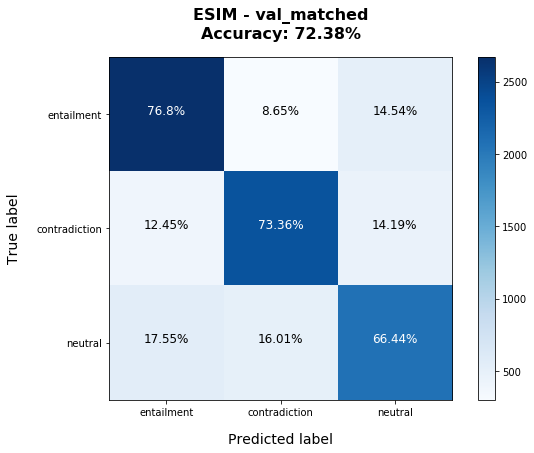

In [22]:
plot_confusion_matrix(labels, predictions, title='%s - %s\nAccuracy: %0.2f%%'
                                                  % (args.model_type, 'val_matched', accuracy))

In [23]:
def print_samples(label, prediction, samples = 5):
    idx = np.logical_and(labels == label, predictions == prediction)
    n = np.sum(idx)
    
    selection = np.random.choice(range(n), size=samples)
    
    p = premises[idx][selection]
    h = hypotheses[idx][selection]
    
    print('TRUE LABEL: %s\nPREDICTION: %s\n' % (class_map[label], class_map[prediction]))
    
    for i in range(samples):
        print('Sample %s' % (i+1))
        print('Premise: ' + ' '.join(p[i]))
        print('Hypothesis: ' + ' '.join(h[i]))
        print('-------------------------------------------------------\n')

In [24]:
for i in range(2):
    for j in range(2):
        print_samples(i, j)

TRUE LABEL: entailment
PREDICTION: entailment

Sample 1
Premise: and , although i got a ph.d. in philosophy many years ago and have thought and read about these matters ever since , heaven ( or whatever ) knows i do n't have too many answers that i feel confident about .
Hypothesis: i have been thinking about this since i earned my degree , but i still do n't know for sure .
-------------------------------------------------------

Sample 2
Premise: the journal put the point succinctly to is any publicity good publicity ?
Hypothesis: the journal asked `` is any publicity good publicity ? ''
-------------------------------------------------------

Sample 3
Premise: oh yes how well i know i was laid off last year but i was i was lucky because i was one of the first groups to go
Hypothesis: my group was one of the first to get laid off last year .
-------------------------------------------------------

Sample 4
Premise: err ... i do n't know .
Hypothesis: i am not sure .
-----------------

In [25]:
n_correct, predictions, labels, premises, hypotheses, real_labels = evaluate(val_iter_unmatched, model)

In [26]:
accuracy = n_correct / len(val_iter_unmatched.dataset) * 100
print("Accuracy: {0}".format(accuracy))

Accuracy: 72.07078925956061


Normalized confusion matrix
[[ 79.24   7.62  13.14]
 [ 13.3   71.39  15.31]
 [ 18.63  16.52  64.84]]


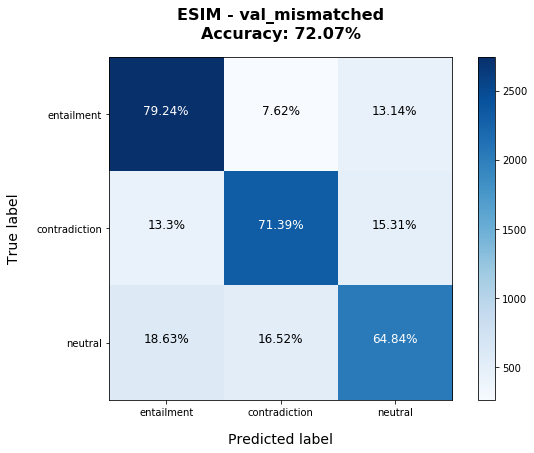

In [27]:
plot_confusion_matrix(labels, predictions, title='%s - %s\nAccuracy: %0.2f%%'
                                                  % (args.model_type, 'val_mismatched', accuracy))

In [28]:
for i in range(2):
    for j in range(2):
        print_samples(i, j)

TRUE LABEL: entailment
PREDICTION: entailment

Sample 1
Premise: if i was n't working here .
Hypothesis: if i was working elsewhere than here .
-------------------------------------------------------

Sample 2
Premise: al qaeda helped jemaah islamiya ( ji ) , a nascent organization headed by indonesian islamists with cells scattered across malaysia , singapore , indonesia , and the philippines .
Hypothesis: al qaeda had a hand in assisting jemaah islamiya .
-------------------------------------------------------

Sample 3
Premise: i just loved cinderella . i also saw my sisters as the wicked stepsisters sometimes , and i was cinderella , running around waiting on them .
Hypothesis: my sisters were very similar in temperament to the wicked stepsisters from cinderella .
-------------------------------------------------------

Sample 4
Premise: excessive stimulation also causes them to withdraw as they try to shield themselves from a stimulus deluge , thereby creating conditions that , pa